<a href="https://colab.research.google.com/github/FiyonaK/Project-2/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importing necessary tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

#Importing the Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [210]:
#Load data
df_str = pd.read_csv('/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week09/Data/healthcare-dataset-stroke-data.csv')

df_str.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


1. Source of data:

  https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

2. Brief description of data:

  According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
  This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status

3. What is the target?  

  stroke: 1 if the patient had a stroke or 0 if not

4. What does one row represent? (A person? A business? An event? A product?)

  Each row in the data provides relevant information about the patient.

5. Is this a classification or regression problem?

  Classification

In [211]:
df_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


6. How many features does the data have?

  12 columns/features

7. How many rows are in the dataset?

  5110

8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Possible imbalance of data and finding the right techqinues/parameters to model an imbalanced dataset correctly.
Deciding the correct standardization, imputation and modeling strategies to use to get the most accurate predictions.

##Data Cleaning

In [212]:
#Delete unnecessary columns
df_str = df_str.drop(columns = ['id', 'Residence_type'])
df_str.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1


Note: I chose to leave the 'married' column in as I am intrigued to see the effect of marriage (or not) on stroke prediction.

Also left work_type in as I believe this could also have an impact on the predictions.

In [213]:
#Check for duplicate rows.
df_str.duplicated().sum()

0

There are no duplicate rows to delete

In [214]:
#Check the data balance
df_str['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [215]:
#Identify inconsistencies in data for categorical values (i.e. Cat, cat, cats).
#Display value counts for categorical columns
for col in df_str.select_dtypes(include='object').columns:
  display(df_str[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

There are no inconsistent categories in the categorical columns.

In [216]:
#Identify missing values.
df_str.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

bmi column has 201 missing values, which we will impute with median since we seem to have an extemely imbalanced dataset.

In [217]:
#Make a copy of the data for modeling (since we have already cleaned the data, but before imputing missing values as we do not want
#any data leakage)
df = df_str.copy()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,174.12,24.0,never smoked,1


In [218]:
#Impute missing values in bmi column with median
df_str['bmi'] = df_str['bmi'].fillna(df_str['bmi'].median())

In [219]:
#Confirm that there are no more missing values
df_str.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

###Produce univariate visuals for the target and all features.

In [220]:
#Univariate EDA Functions

# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source: https://login.codingdojo.com/m/717/16237/120173
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source: https://login.codingdojo.com/m/717/16237/120173
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


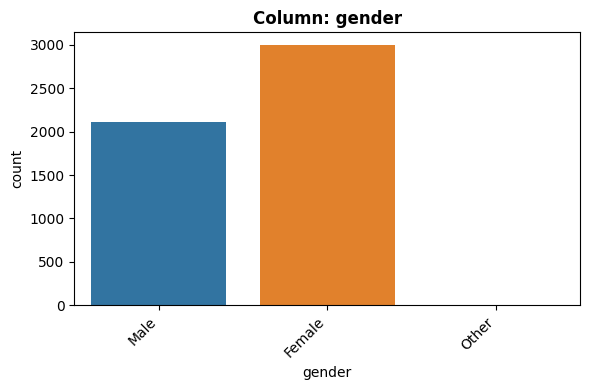

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Female' occurs 2994 times (58.59%)
- Not constant or quasi-constant.


In [221]:
#Plot Univariate visual for gender column
explore_categorical(df_str, 'gender', fillna=False);

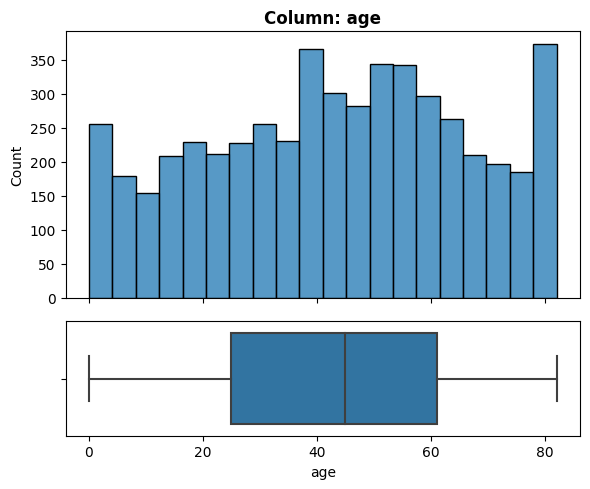

- NaN's Found: 0 (0.0%)
- Unique Values: 104
- Most common value: '78.0' occurs 102 times (2.0%)
- Not constant or quasi-constant.


In [222]:
#Plot Univariate visuals for age column
explore_numeric(df_str, 'age');

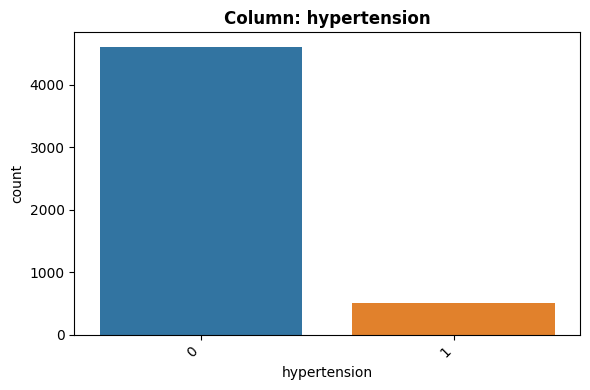

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4612 times (90.25%)
- Not constant or quasi-constant.


In [223]:
#Plot Univariate visuals for hypertension column
explore_categorical(df_str, 'hypertension', fillna=False);

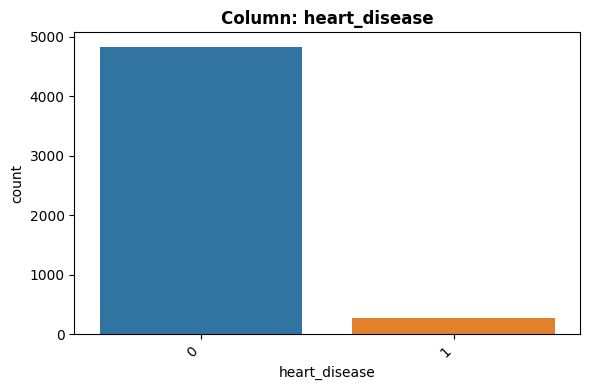

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4834 times (94.6%)
- Not constant or quasi-constant.


In [224]:
#Plot Univariate visuals for heart_disease column
explore_categorical(df_str, 'heart_disease', fillna=False);

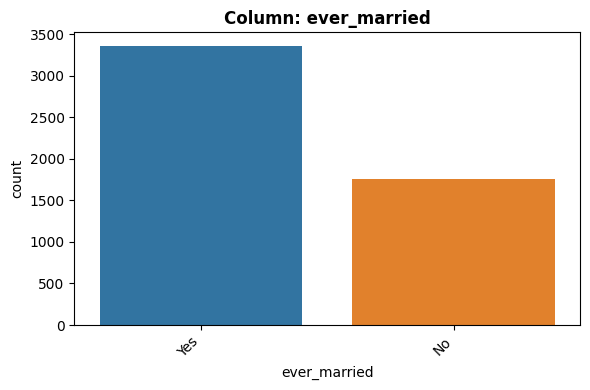

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Yes' occurs 3353 times (65.62%)
- Not constant or quasi-constant.


In [225]:
#Plot Univariate visuals for ever_married column
explore_categorical(df_str, 'ever_married', fillna=False);

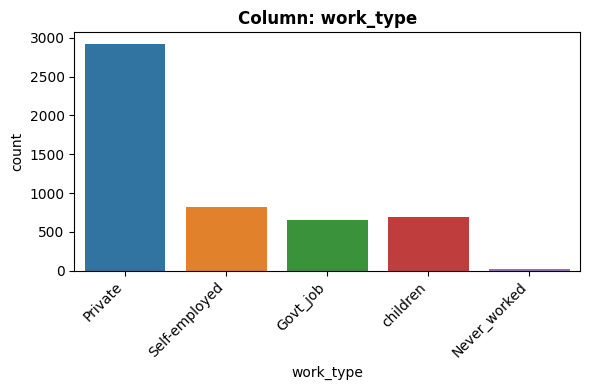

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'Private' occurs 2925 times (57.24%)
- Not constant or quasi-constant.


In [226]:
#Plot Univariate visuals for work_type column
explore_categorical(df_str, 'work_type', fillna=False);

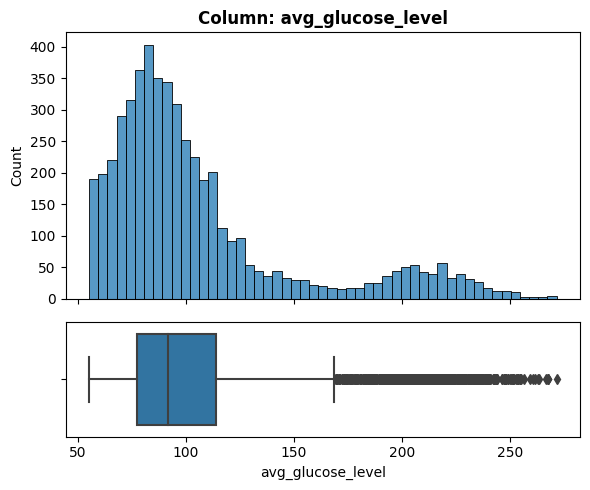

- NaN's Found: 0 (0.0%)
- Unique Values: 3979
- Most common value: '93.88' occurs 6 times (0.12%)
- Not constant or quasi-constant.


In [227]:
#Plot Univariate visuals for avg_glucose_level column
explore_numeric(df_str, 'avg_glucose_level');

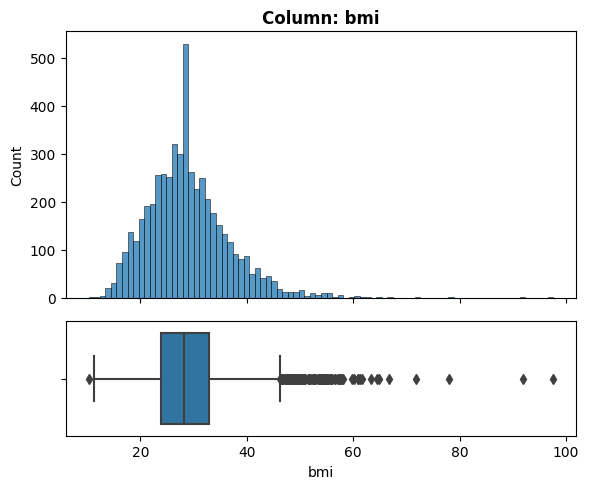

- NaN's Found: 0 (0.0%)
- Unique Values: 418
- Most common value: '28.1' occurs 230 times (4.5%)
- Not constant or quasi-constant.


In [228]:
#Plot Univariate visuals for bmi column
explore_numeric(df_str, 'bmi');

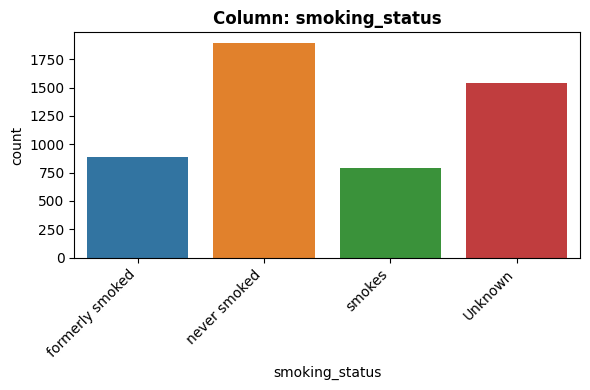

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'never smoked' occurs 1892 times (37.03%)
- Not constant or quasi-constant.


In [229]:
#Plot Univariate visuals for smoking_status column
explore_categorical(df_str, 'smoking_status', fillna=False);

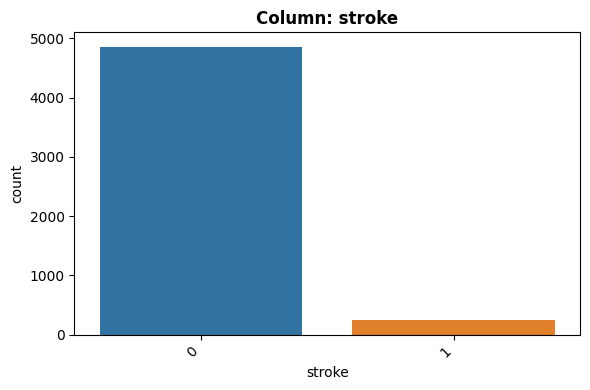

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 4861 times (95.13%)
- Not constant or quasi-constant.


In [230]:
#Plot Univariate visuals for stroke column
explore_categorical(df_str, 'stroke', fillna=False);

In [231]:
#Identify outliers.
df_str.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


As can be seen from the boxplots and descriptive statistics above, we have some outliers in the following columns:
  - age:
    
    Age column has a minimum value of 0.08. Presuming this data is for adults only, this is an impossible value.

  - avg_glucose_level:
    
    Lots of outliers in this column. Also has a maximum value of 271 which is very high but not impossible. This glucose level would require immediate medical attention.

  - bmi:

    bmi has an almost impossible minimum and maximum value. A min value of 10 would indicate the person is severely underweight and could be life threatening, while a max value of 97.6 is highly improbable. Generally speaking, a BMI of between 40 and 69 already indicates morbid obesity.

###Identify any moderate or strong correlations between your target and your features and/or between one feature and another using a correlation heatmap.


In [232]:
corr = df_str.corr()
corr.round(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.32,0.25
hypertension,0.28,1.00,0.11,0.17,0.16,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.17,0.13
bmi,0.32,0.16,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


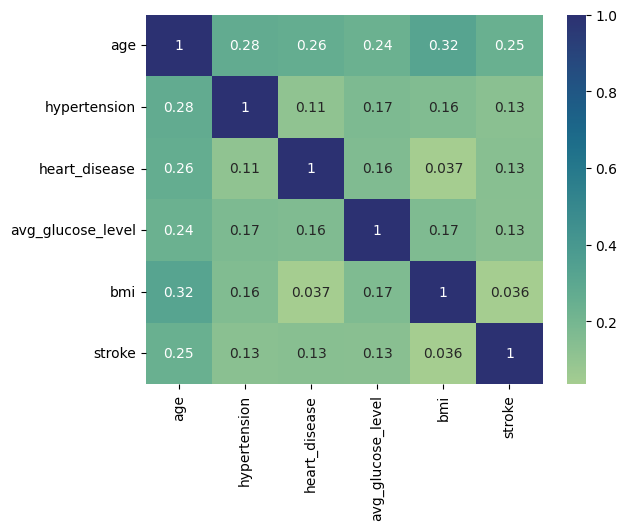

In [233]:
ax = sns.heatmap(corr, cmap = 'crest', annot = True)

Interpretation: There seems to be a moderate positive correlation of all the numeric features against the age feature.

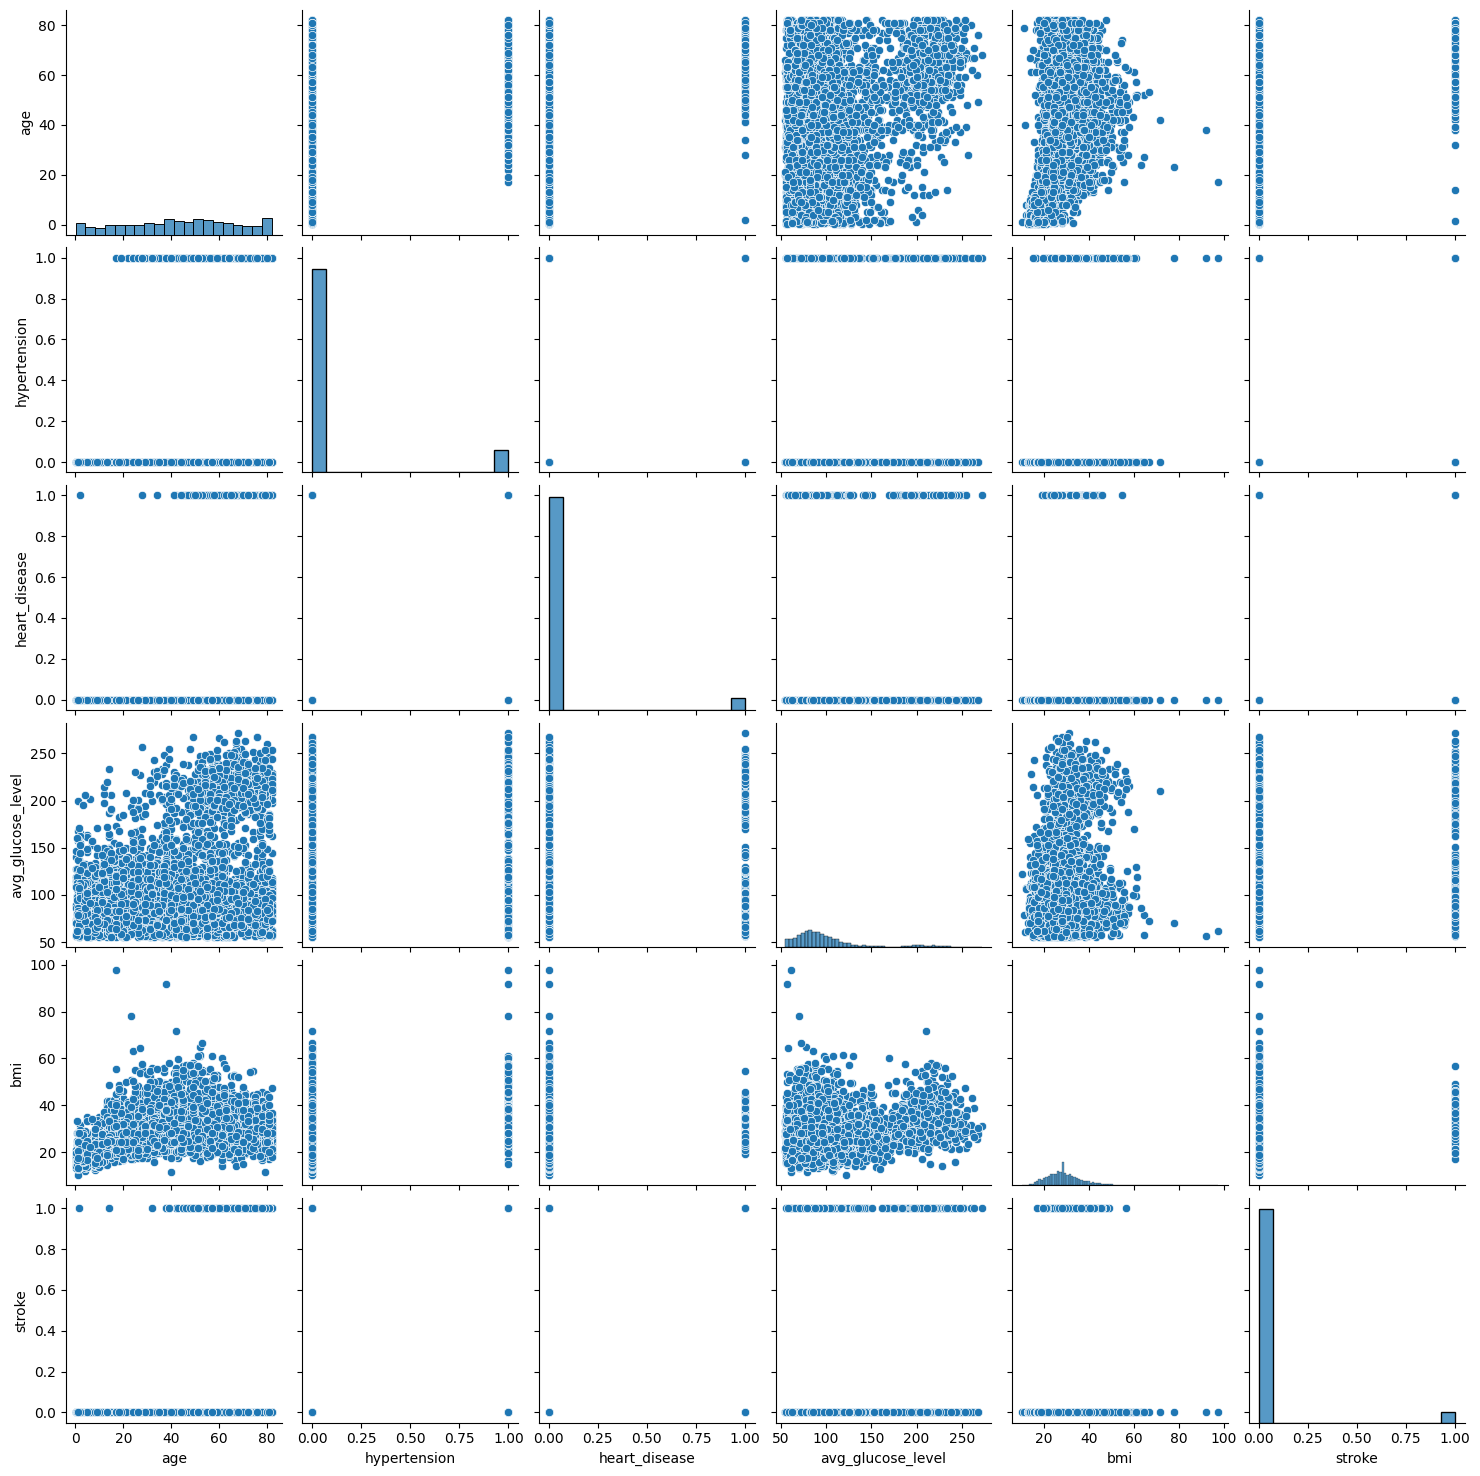

In [234]:
#Using sns pairplot to plot the relationships between all numeric variables
sns.pairplot(df_str);

Source: https://www.kdnuggets.com/2022/04/data-visualization-python-seaborn.html

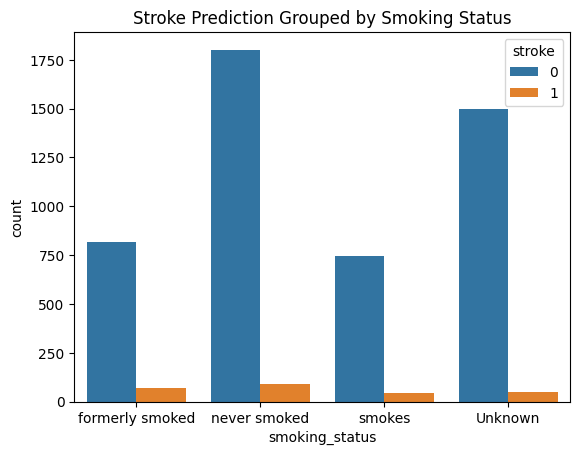

In [235]:
ax = sns.countplot(data=df_str, hue='stroke', x='smoking_status')
ax.set_title("Stroke Prediction Grouped by Smoking Status");

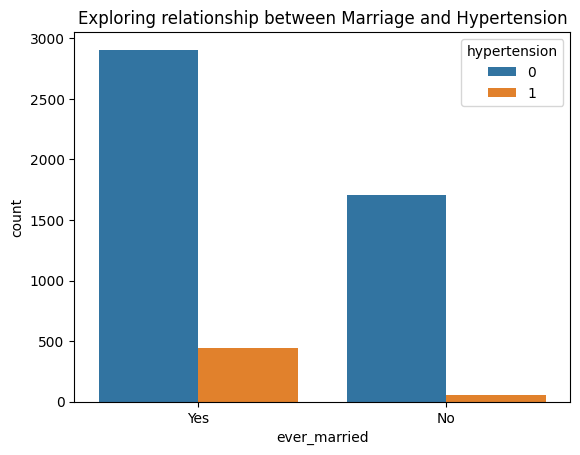

In [236]:
ax = sns.countplot(data=df_str, hue='hypertension', x='ever_married')
ax.set_title("Exploring relationship between Marriage and Hypertension");

Just as suspected! Marriage is a higher contributing factor to hypertension vs not married.

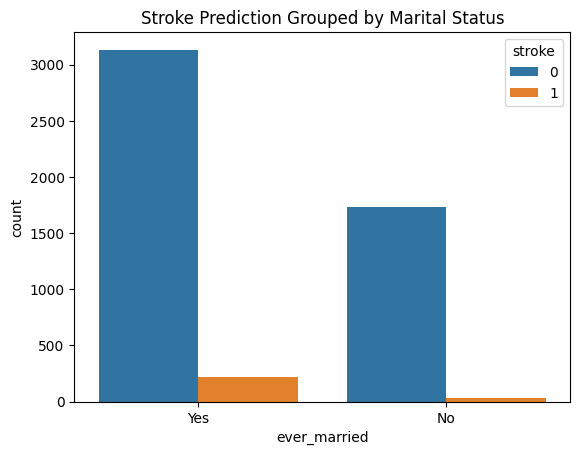

In [237]:
ax = sns.countplot(data=df_str, hue='stroke', x='ever_married')
ax.set_title("Stroke Prediction Grouped by Marital Status");

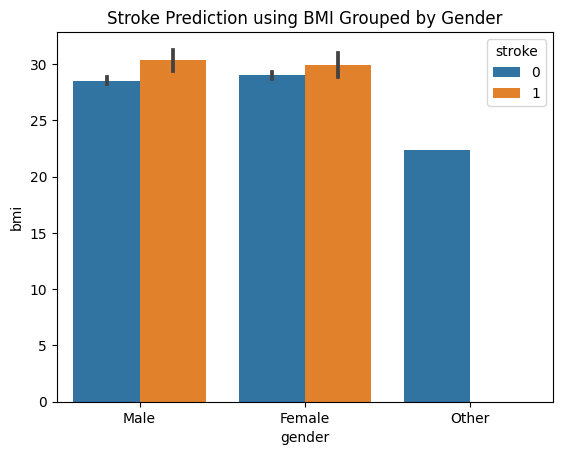

In [238]:
ax = sns.barplot(data=df_str, y="bmi", x="gender", hue='stroke')

ax.set_title("Stroke Prediction using BMI Grouped by Gender");

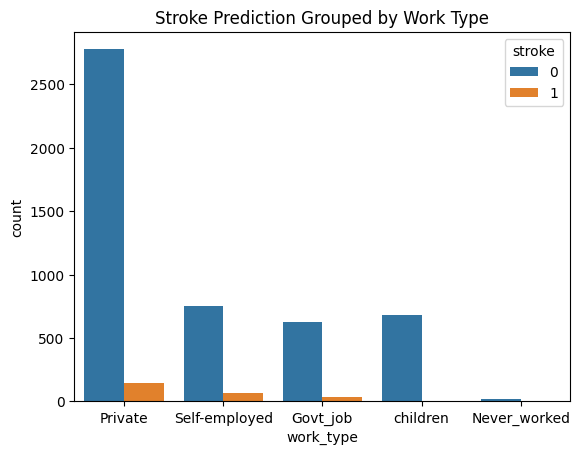

In [239]:
ax = sns.countplot(data=df_str, hue='stroke', x='work_type')
ax.set_title("Stroke Prediction Grouped by Work Type");

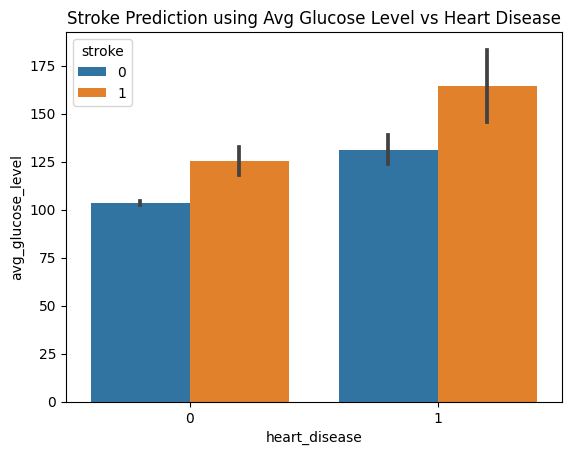

In [240]:
ax = sns.barplot(data=df_str, y="avg_glucose_level", x="heart_disease", hue='stroke')

ax.set_title("Stroke Prediction using Avg Glucose Level vs Heart Disease");

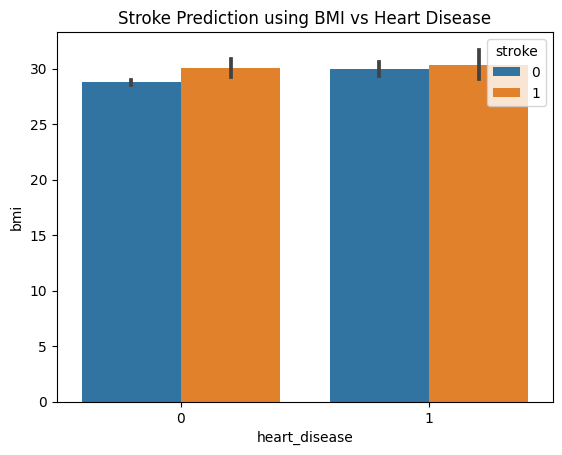

In [241]:
ax = sns.barplot(data=df_str, y="bmi", x="heart_disease", hue='stroke')

ax.set_title("Stroke Prediction using BMI vs Heart Disease");

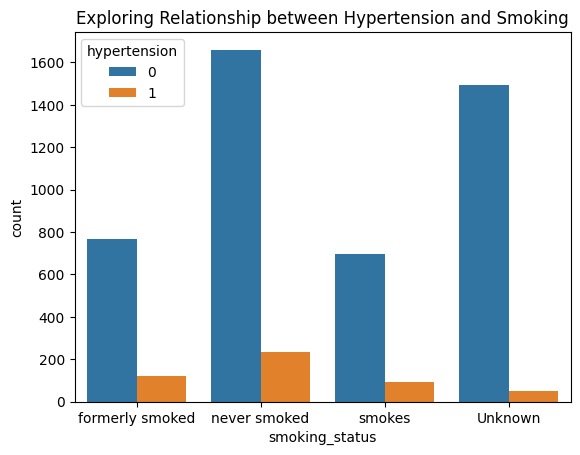

In [242]:
ax = sns.countplot(data=df_str, hue='hypertension', x='smoking_status')

ax.set_title("Exploring Relationship between Hypertension and Smoking");

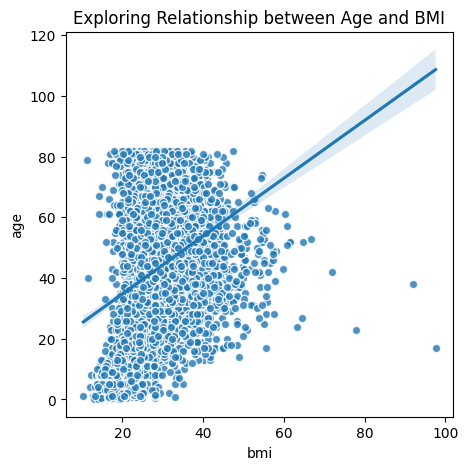

In [243]:
  fig, ax = plt.subplots(figsize=(5,5))
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df_str, x='bmi', y='age', ax=ax, scatter_kws=scatter_kws)
  ax.set_title("Exploring Relationship between Age and BMI");

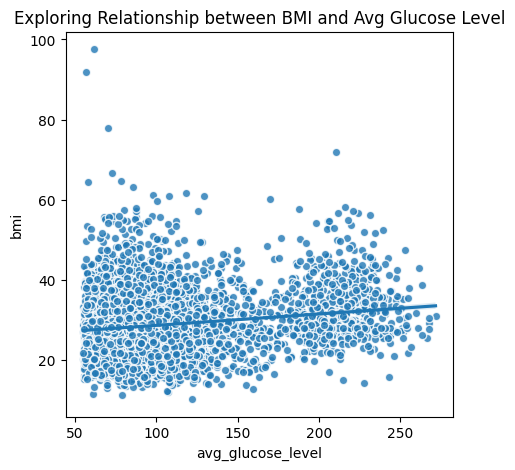

In [244]:
  fig, ax = plt.subplots(figsize=(5,5))
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df_str, x='avg_glucose_level', y='bmi', ax=ax, scatter_kws=scatter_kws)
  ax.set_title("Exploring Relationship between BMI and Avg Glucose Level");

###Choose two visualizations from your analysis that demonstrate key trends you found that will be of interest to a stakeholder.

####VISUAL 1 - Glucose Level vs Heart Disease

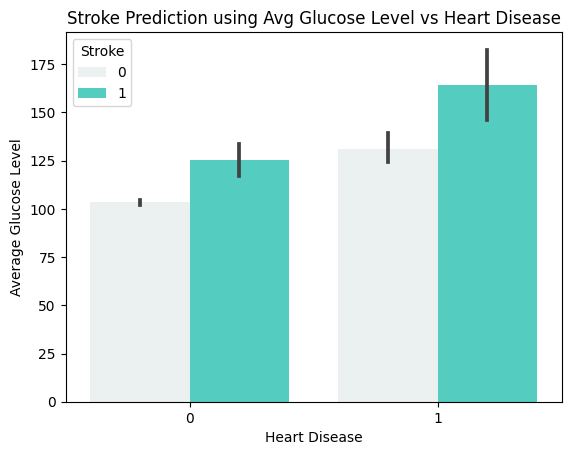

In [245]:
ax = sns.barplot(data=df_str, y="avg_glucose_level", x="heart_disease", hue='stroke', color='turquoise')

plt.xlabel("Heart Disease")
plt.ylabel("Average Glucose Level")
plt.legend(title='Stroke')
ax.set_title("Stroke Prediction using Avg Glucose Level vs Heart Disease")
plt.show();

In this visual we explored the relationship between a person's average glucose level and heart disease in predicting a stroke. Interestingly enough, in both cases, a higher average glucose level seems to contribute to a stroke, regardless of whether the individual presents with heart disease or not.

Additionally, it should be noted that higher average glucose levels may also contribute to the development of heart disease in an individual.

####VISUAL 2 - Hypertension vs Smoking

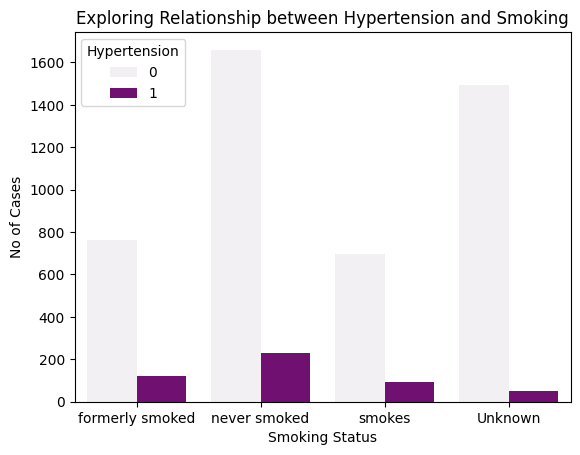

In [246]:
ax = sns.countplot(data=df_str, hue='hypertension', x='smoking_status', color='purple')

plt.xlabel("Smoking Status")
plt.ylabel("No of Cases")
plt.legend(title='Hypertension')
ax.set_title("Exploring Relationship between Hypertension and Smoking")
plt.show();

In the above visual we explored the relationship between smoking and hypertension. As can be seen from the above, the highest number of hypertensive cases presented in those who have never smoked! There are lower cases of hypertension in those that currently smoke, and those who have stopped smoking.

This is the complete opposite to what was expected. It seems that, according to our data, smoking does not play a big part in causing hypertension, if at all.

##Modeling

###Preprocessing

In [247]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [248]:
df.loc[df['age'] < 18]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,57.93,30.9,Unknown,1
249,Male,3.00,0,0,No,children,95.12,18.0,Unknown,0
251,Female,8.00,0,0,No,Private,110.89,17.6,Unknown,0
253,Male,14.00,0,0,No,Never_worked,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...
5089,Female,0.72,0,0,No,children,62.13,16.8,Unknown,0
5094,Male,13.00,0,0,No,children,82.38,24.3,Unknown,0
5095,Male,1.08,0,0,No,children,79.15,17.4,Unknown,0
5098,Male,9.00,0,0,No,children,71.88,17.5,Unknown,0


In [249]:
df.shape

(5110, 10)

In [250]:
#Drop rows with impossible age values (<18)
indexAge = df[df['age'] < 18].index
df.drop(indexAge , inplace=True)
df.shape

(4254, 10)

In [251]:
df.loc[df['age'] < 18]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke


In [252]:
#Check for missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
avg_glucose_level      0
bmi                  181
smoking_status         0
stroke                 0
dtype: int64

In [253]:
#Define X and y and train, test, split
X = df.drop(columns = ['stroke'])

y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

display(X_train.head(), y_train.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
522,Male,40.0,0,0,Yes,Private,89.77,NaN,smokes
811,Male,41.0,0,0,Yes,Private,82.32,27.9,Unknown
3916,Female,66.0,0,0,Yes,Private,95.37,34.5,smokes
1107,Female,22.0,0,0,No,Private,73.40,21.6,never smoked
1221,Male,20.0,0,0,No,Private,96.20,21.5,never smoked


522     0
811     0
3916    0
1107    0
1221    0
Name: stroke, dtype: int64

In [254]:
#Create lists of column names for numeric and categorical columns.
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

cat_cols =  X_train.select_dtypes("object").columns
print("Categorical Columns:", cat_cols)

Numeric Columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')
Categorical Columns: Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object')


In [255]:
#create pipeline for numeric columns
#imputing missing values in bmi column with median since we have a highly imbalanced dataset
med_imputer = SimpleImputer(strategy='median')
num_scaler = StandardScaler()
num_pipe = make_pipeline(med_imputer, num_scaler)

num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [256]:
#create pipeline for categorical column
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [257]:
#Create a tuple for each transformer with the: name, the transformer object, and the list of columns.
num_tuple = ('numeric', num_pipe, num_cols)
print(num_tuple)

cat_tuple = ('categorical',cat_pipe, cat_cols)
print(cat_tuple)

('numeric', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object'))
('categorical', Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))


In [258]:
#Use the tuples to create a ColumnTransformer
preprocessor = ColumnTransformer([num_tuple, cat_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                  verbose_feature_names_out=False)

In [259]:
#Fit the ColumnTransformer on your training data.
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                  verbose_feature_names_out=False)

In [260]:
#Transform the training data
X_train_processed = preprocessor.transform(X_train)
X_train_processed

array([[-0.55754633, -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  1.        ],
       [-0.5018371 , -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89089358, -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67082277,  2.74397736, -0.26613744, ...,  0.        ,
         1.        ,  0.        ],
       [-1.00322015, -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.39227663,  2.74397736,  3.75745704, ...,  1.        ,
         0.        ,  0.        ]])

In [261]:
#Transform the test data
X_test_processed = preprocessor.transform(X_test)
X_test_processed

array([[ 0.7237659 , -0.36443449, -0.26613744, ...,  1.        ,
         0.        ,  0.        ],
       [-0.22329097, -0.36443449, -0.26613744, ...,  0.        ,
         1.        ,  0.        ],
       [-0.61325556, -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.00231204, -0.36443449, -0.26613744, ...,  0.        ,
         1.        ,  0.        ],
       [-0.78038324, -0.36443449, -0.26613744, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.7237659 , -0.36443449, -0.26613744, ...,  0.        ,
         0.        ,  1.        ]])

###Fit and evaluate multiple types of models on your data.

In [262]:
def evaluate_model(model_pipe, X_train, y_train, X_test, y_test):
  # Get predictions
  y_pred_train = model_pipe.predict(X_train)
  y_pred_test = model_pipe.predict(X_test)

  # Accuracy
  train_accuracy = accuracy_score(y_train, y_pred_train)
  test_accuracy = accuracy_score(y_test, y_pred_test)

  print(f'Training accuracy: {train_accuracy:.2f}')
  print(f'Test accuracy: {test_accuracy:.2f}')
  print()

  # Precision
  train_precision = precision_score(y_train, y_pred_train)
  test_precision = precision_score(y_test, y_pred_test)

  print(f'Training precision: {train_precision:.2f}')
  print(f'Test precision: {test_precision:.2f}')
  print()


  # Recall
  train_recall = recall_score(y_train, y_pred_train)
  test_recall = recall_score(y_test, y_pred_test)

  print(f'Training Recall: {train_recall:.2f}')
  print(f'Test Recall: {test_recall:.2f}')
  print()


  # roc_auc
  y_pred_proba_train = model_pipe.predict_proba(X_train)
  y_pred_proba_test = model_pipe.predict_proba(X_test)
  train_roc_auc = roc_auc_score(y_train, y_pred_proba_train[:,1])
  test_roc_auc = roc_auc_score(y_test, y_pred_proba_test[:,1])

  print(f'Training ROC AUC: {train_roc_auc:.2f}')
  print(f'Test ROC AUC: {test_roc_auc:.2f}')
  print()

#####Logistic Regression Model

In [263]:
%%time
#Instantiate Default Logistic Regression Model
logreg = LogisticRegression()
#Instantiate Pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)
#Fit model on training data
logreg_pipe.fit(X_train, y_train)

CPU times: user 46.8 ms, sys: 19.4 ms, total: 66.2 ms
Wall time: 49.3 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

In [264]:
#Make predictions and retrieve metrics
evaluate_model(logreg_pipe, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.00
Test precision: 0.00

Training Recall: 0.00
Test Recall: 0.00

Training ROC AUC: 0.81
Test ROC AUC: 0.85



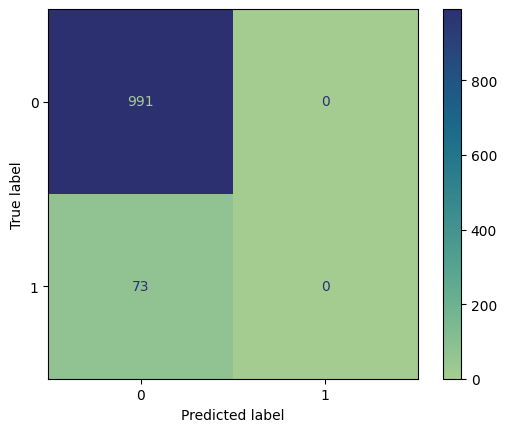

In [265]:
#Plot Confusion Matrix for Default Model
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lr,
                                      cmap = 'crest');

In [266]:
#Obtaining classification report for test data
class_rep_lr = classification_report(y_test, test_preds_lr);
print(f'Classification report for LR Model:\n {class_rep_lr}');

Classification report for LR Model:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       991
           1       0.00      0.00      0.00        73

    accuracy                           0.93      1064
   macro avg       0.47      0.50      0.48      1064
weighted avg       0.87      0.93      0.90      1064



In [267]:
#Get Parameters
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                     verbose_feature_names_ou

In [268]:
#Define parameters to tune
param_grid = {'logisticregression__C': [.001, .01, .1, 1, 10, 100, 1000],
              'logisticregression__penalty' : ['l1', 'l2'],
              'logisticregression__solver': ['liblinear']}
#Instantiate the gridsearch
gridsearch_lr = GridSearchCV(logreg_pipe, param_grid, n_jobs=-1, verbose=1)
#Fit the gridsearch on the training data
gridsearch_lr.fit(X_train, y_train)
#Obtain the best parameters from the gridsearch
gridsearch_lr.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [269]:
%%time
#Define and refit best model
best_lr = gridsearch_lr.best_estimator_
#Make predictions and retrieve metrics
evaluate_model(best_lr, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.00
Test precision: 0.00

Training Recall: 0.00
Test Recall: 0.00

Training ROC AUC: 0.50
Test ROC AUC: 0.50

CPU times: user 68.2 ms, sys: 55.1 ms, total: 123 ms
Wall time: 68.3 ms


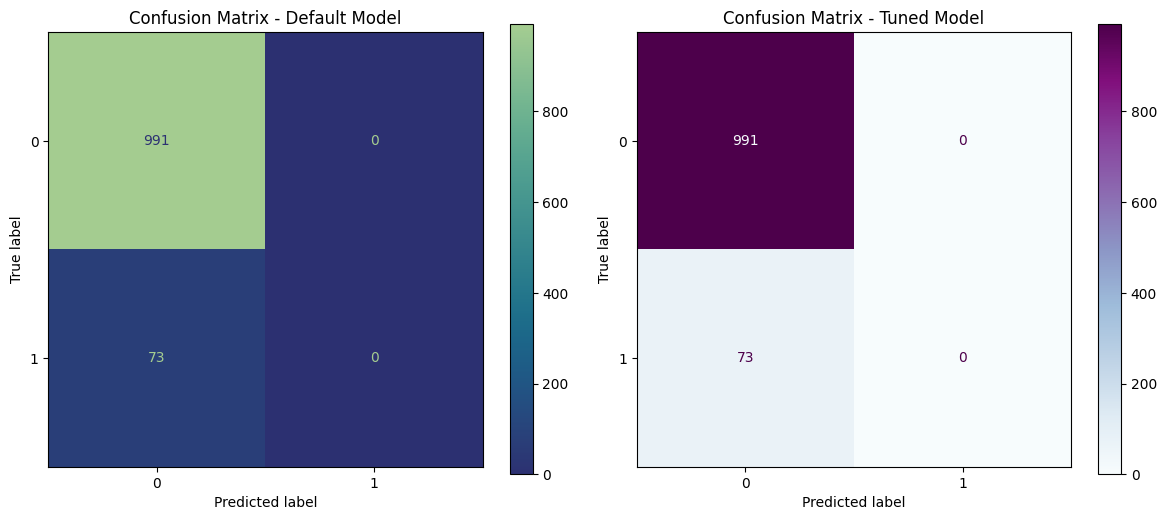

In [270]:
#Plotting default model against tuned model
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_lr, ax = axes[0], cmap = 'crest_r');
axes[0].set_title('Confusion Matrix - Default Model');
ConfusionMatrixDisplay.from_predictions(y_test,test_preds_lr_tuned, ax = axes[1], cmap = 'BuPu');
axes[1].set_title('Confusion Matrix - Tuned Model');
plt.tight_layout()
plt.show()

#####KNN Model

In [271]:
%%time
#Instantiate Default KNN Model
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
#Fit model on training data
knn_pipe.fit(X_train, y_train)

CPU times: user 32.1 ms, sys: 1.06 ms, total: 33.2 ms
Wall time: 41.8 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [272]:
%%time
#Make predictions and retrieve metrics
evaluate_model(knn_pipe, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.56
Test precision: 0.25

Training Recall: 0.05
Test Recall: 0.01

Training ROC AUC: 0.93
Test ROC AUC: 0.62

CPU times: user 1.31 s, sys: 42.1 ms, total: 1.35 s
Wall time: 1.37 s


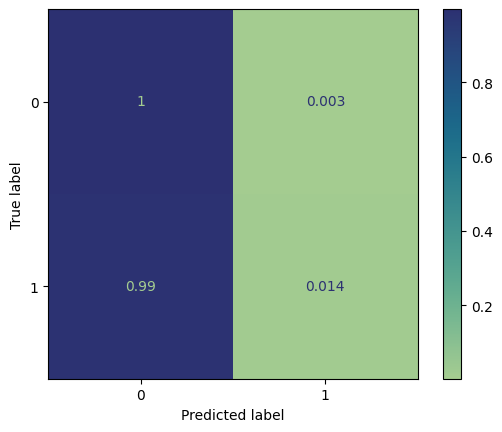

In [273]:
#Plot Confusion Matrix for Default Model
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_knn,
                                      cmap = 'crest', normalize='true');

In [274]:
#Obtaining classification report for test data
class_rep_knn = classification_report(y_test, test_preds_knn);
print(f'Classification report for KNN Model:\n {class_rep_knn}');

Classification report for KNN Model:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       991
           1       0.25      0.01      0.03        73

    accuracy                           0.93      1064
   macro avg       0.59      0.51      0.49      1064
weighted avg       0.89      0.93      0.90      1064



In [275]:
#Get Parameters
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                     verbose_feature_names_ou

In [276]:
#Define parameters to tune
param_grid = {'kneighborsclassifier__p': np.arange(1,5),
              'kneighborsclassifier__leaf_size' : np.arange(1,10),
              'kneighborsclassifier__n_neighbors': np.arange(1,5)}
#Instantiate the gridsearch
gridsearch_knn = GridSearchCV(knn_pipe, param_grid, n_jobs=-1, verbose=1)
#Fit the gridsearch on the training data
gridsearch_knn.fit(X_train, y_train)
#Obtain the best parameters from the gridsearch
gridsearch_knn.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'kneighborsclassifier__leaf_size': 1,
 'kneighborsclassifier__n_neighbors': 4,
 'kneighborsclassifier__p': 2}

In [277]:
%%time
#Define and refit best model
best_knn = gridsearch_knn.best_estimator_
#Make predictions and retrieve metrics
evaluate_model(best_knn, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.67
Test precision: 0.00

Training Recall: 0.01
Test Recall: 0.00

Training ROC AUC: 0.94
Test ROC AUC: 0.58

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.16 s


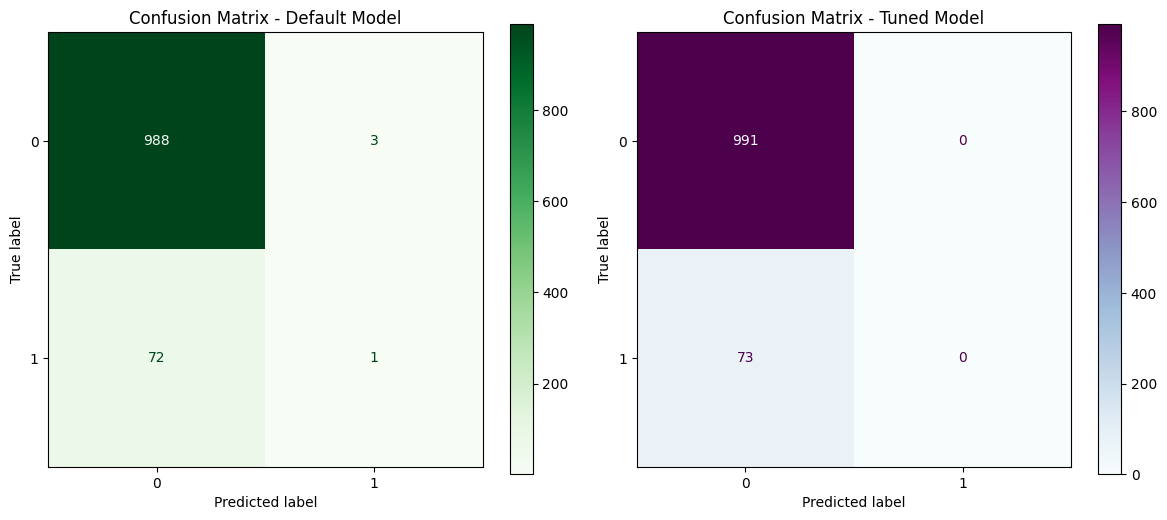

In [278]:
#Plotting default model against tuned model
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_knn, ax = axes[0], cmap = 'Greens');
axes[0].set_title('Confusion Matrix - Default Model');
ConfusionMatrixDisplay.from_predictions(y_test,test_preds_knn_tuned, ax = axes[1], cmap = 'BuPu');
axes[1].set_title('Confusion Matrix - Tuned Model');
plt.tight_layout()
plt.show()

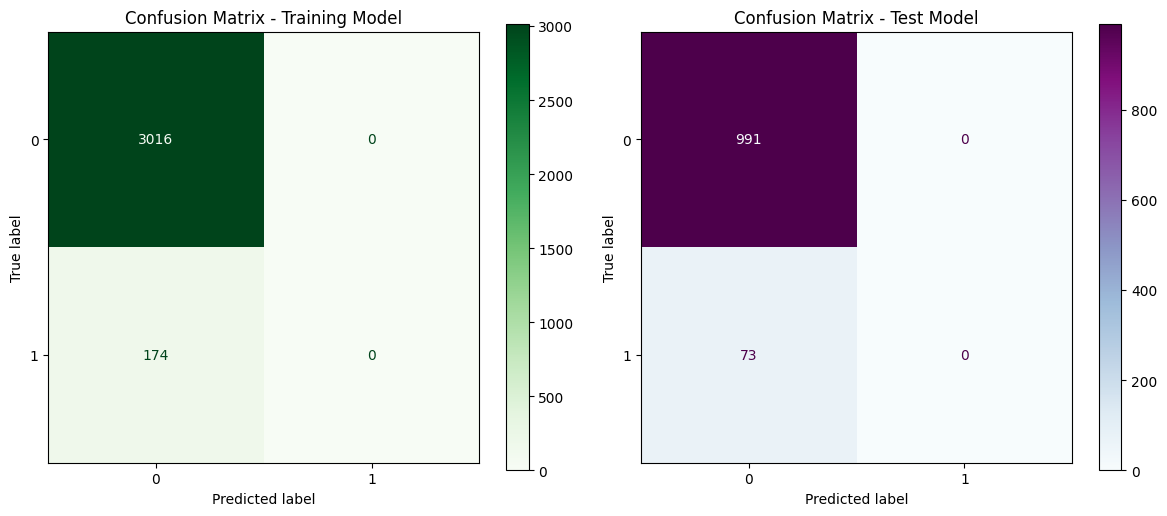

In [279]:
#Plotting training model against test model
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(best_lr, X_train, y_train, ax = axes[0], cmap = 'Greens');
axes[0].set_title('Confusion Matrix - Training Model');
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, ax = axes[1], cmap = 'BuPu');
axes[1].set_title('Confusion Matrix - Test Model');
plt.tight_layout()
plt.show()

In [280]:
#Obtaining classification report for test data - tuned
class_rep_knn = classification_report(y_test, test_preds_knn_tuned);
print(f'Classification report for KNN Model - Tuned:\n {class_rep_knn}');

Classification report for KNN Model - Tuned:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       991
           1       0.00      0.00      0.00        73

    accuracy                           0.93      1064
   macro avg       0.47      0.50      0.48      1064
weighted avg       0.87      0.93      0.90      1064



#####Random Forest Model

In [281]:
%%time
#Instantiate default random forest model
rf = RandomForestClassifier()
rf_pipe = make_pipeline(preprocessor, rf)
#Fit model on training data
rf_pipe.fit(X_train, y_train)

CPU times: user 569 ms, sys: 0 ns, total: 569 ms
Wall time: 585 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier', RandomForestClassifier())])

In [282]:
%%time
#Make predictions and retrieve metrics
evaluate_model(rf_pipe, X_train, y_train, X_test, y_test)

Training accuracy: 1.00
Test accuracy: 0.93

Training precision: 1.00
Test precision: 0.00

Training Recall: 1.00
Test Recall: 0.00

Training ROC AUC: 1.00
Test ROC AUC: 0.78

CPU times: user 190 ms, sys: 0 ns, total: 190 ms
Wall time: 192 ms


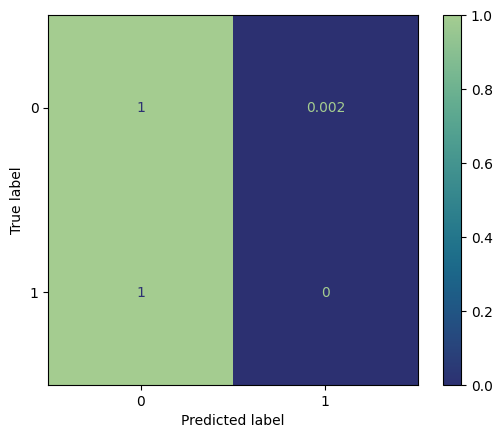

In [283]:
#Plot Confusion Matrix for Default Model - Normalized
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_rf,
                                      cmap = 'crest_r', normalize = 'true');

In [284]:
#Obtaining classification report for test data
class_rep_rf = classification_report(y_test, test_preds_rf);
print(f'Classification report for Random Forest Model:\n {class_rep_rf}');

Classification report for Random Forest Model:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       991
           1       0.00      0.00      0.00        73

    accuracy                           0.93      1064
   macro avg       0.47      0.50      0.48      1064
weighted avg       0.87      0.93      0.90      1064



In [285]:
#Get Parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                     verbose_feature_names_ou

In [286]:
#Define parameters to tune
param_grid = {'randomforestclassifier__max_depth' : np.arange(1,11),
              'randomforestclassifier__min_samples_leaf' : np.arange(1,11)}
#Instantiate the gridsearch
gridsearch_rf = GridSearchCV(rf_pipe, param_grid, n_jobs=-1, verbose=1)
#Fit the gridsearch on the training data
gridsearch_rf.fit(X_train, y_train)
#Obtain the best parameters from the gridsearch
gridsearch_rf.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'randomforestclassifier__max_depth': 1,
 'randomforestclassifier__min_samples_leaf': 1}

In [287]:
%%time
#Define and refit best model
best_rf = gridsearch_rf.best_estimator_
#Make predictions and retrieve metrics
evaluate_model(best_rf, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.00
Test precision: 0.00

Training Recall: 0.00
Test Recall: 0.00

Training ROC AUC: 0.79
Test ROC AUC: 0.82

CPU times: user 118 ms, sys: 3.57 ms, total: 122 ms
Wall time: 124 ms


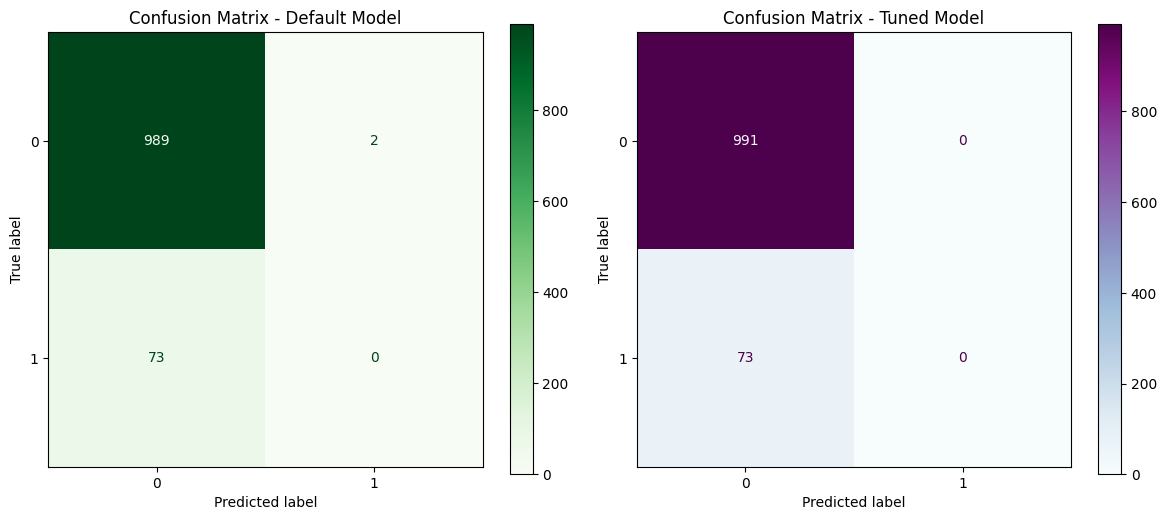

In [288]:
#Plotting default model against tuned model
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_rf, ax = axes[0], cmap = 'Greens');
axes[0].set_title('Confusion Matrix - Default Model');
ConfusionMatrixDisplay.from_predictions(y_test,test_preds_rf_tuned, ax = axes[1], cmap = 'BuPu');
axes[1].set_title('Confusion Matrix - Tuned Model');
plt.tight_layout()
plt.show()

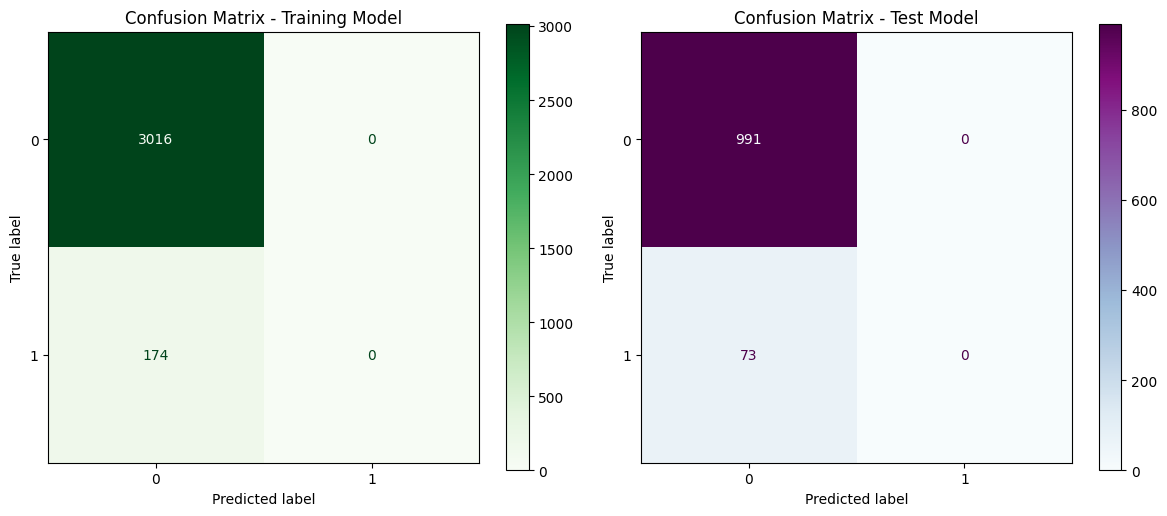

In [289]:
#Plotting training model against test model
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_train, y_train, ax = axes[0], cmap = 'Greens');
axes[0].set_title('Confusion Matrix - Training Model');
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax = axes[1], cmap = 'BuPu');
axes[1].set_title('Confusion Matrix - Test Model');
plt.tight_layout()
plt.show()

In [290]:
#Obtaining classification report for test data - tuned
class_rep_rf = classification_report(y_test, test_preds_rf_tuned);
print(f'Classification report for Random Forest Model - Tuned:\n {class_rep_rf}');

Classification report for Random Forest Model - Tuned:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       991
           1       0.00      0.00      0.00        73

    accuracy                           0.93      1064
   macro avg       0.47      0.50      0.48      1064
weighted avg       0.87      0.93      0.90      1064



#####PCA (Principal Component Analysis)

In [291]:
#Apply PCA to data to retain 95% of the variance
scaler = StandardScaler()
pca = PCA(n_components=.95)
pca_preprocessor = make_pipeline(preprocessor, pca, scaler)

pca_train = pca_preprocessor.fit_transform(X_train)
print('Shape before PCA: ', preprocessor.fit_transform(X_train).shape)
print('Shape after PCA: ', pca_train.shape)

Shape before PCA:  (3190, 18)
Shape after PCA:  (3190, 10)


In [292]:
%%time
# Now we will build the pipeline
logreg_pipe_pca = make_pipeline(preprocessor, pca, logreg)

# fit the pipeline
logreg_pipe_pca.fit(X_train, y_train)

CPU times: user 41.7 ms, sys: 49.1 ms, total: 90.8 ms
Wall time: 48.5 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression())])

In [293]:
%%time
#Make predictions and retrieve metrics
evaluate_model(logreg_pipe_pca, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.00
Test precision: 0.00

Training Recall: 0.00
Test Recall: 0.00

Training ROC AUC: 0.81
Test ROC AUC: 0.85

CPU times: user 77.9 ms, sys: 53 ms, total: 131 ms
Wall time: 79.9 ms


In [294]:
%%time
# Now we will build the pipeline
knn_pipe_pca = make_pipeline(preprocessor, pca, knn)

# fit the pipeline
knn_pipe_pca.fit(X_train, y_train)

CPU times: user 36 ms, sys: 32.6 ms, total: 68.6 ms
Wall time: 41.5 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [295]:
%%time
#Make predictions and retrieve metrics
evaluate_model(knn_pipe_pca, X_train, y_train, X_test, y_test)

Training accuracy: 0.95
Test accuracy: 0.93

Training precision: 0.59
Test precision: 0.33

Training Recall: 0.06
Test Recall: 0.01

Training ROC AUC: 0.93
Test ROC AUC: 0.62

CPU times: user 528 ms, sys: 216 ms, total: 744 ms
Wall time: 521 ms


In [296]:
%%time
# Now we will build the pipeline
rf_pipe_pca = make_pipeline(preprocessor, pca, rf)

# fit the pipeline
rf_pipe_pca.fit(X_train, y_train)

CPU times: user 1.16 s, sys: 105 ms, total: 1.27 s
Wall time: 1.16 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier', RandomForestClassifier())])

In [297]:
%%time
#Make predictions and retrieve metrics
evaluate_model(rf_pipe_pca, X_train, y_train, X_test, y_test)

Training accuracy: 1.00
Test accuracy: 0.93

Training precision: 1.00
Test precision: 0.25

Training Recall: 1.00
Test Recall: 0.01

Training ROC AUC: 1.00
Test ROC AUC: 0.73

CPU times: user 262 ms, sys: 184 ms, total: 446 ms
Wall time: 244 ms


Choose your "production" model and justify this decision using the metrics most important to your business problem.

This is a classification task with stroke as the target feature. Our main aim in making predictions with any of these models is to minimize/reduce false negatives, as an incorrect negative stroke prediction could prove life threatening to the particular patient.

In the above instances, the KNN model with PCA applied provided the highest overall accuracy score for the test data, as well as the highest precision score of all the models used. The instances where the precision and recall scores were 0, indicates that there were no true positives and therefore our model was not a good one. This could also be due to the highly imbalanced dataset we are working with.

Since we are trying to minimize false negatives, we should aim to tune our model to improve the recall score, and this may also improve our overall accuracy score.